In [7]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn as nn
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import kaggle
from torch.utils.data import DataLoader, ConcatDataset, random_split
from sklearn.metrics import roc_auc_score, roc_curve

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != "cuda":
    print("У вас система не потянет такое учить!")
device

device(type='cuda')

In [9]:
dataset_url = "sanikamal/horses-or-humans-dataset"
data_path = "data"
models_path = "models"
directory_name = "horse-or-human"
dataset_path = os.path.join(data_path, directory_name)

train_path = os.path.join(dataset_path, "train")
validation_path = os.path.join(dataset_path, "validation")

if directory_name not in os.listdir(data_path):
    kaggle.api.dataset_download_files(dataset_url, data_path, unzip=True)

In [11]:
IMG_SIZE = 150

augmentation_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
    ]
)

base_transforms = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()]
)

In [12]:
# Загрузка
train_dataset = datasets.ImageFolder(root=train_path, transform=base_transforms)
val_dataset = datasets.ImageFolder(root=validation_path, transform=base_transforms)

all_data = ConcatDataset([train_dataset, val_dataset])

test_size = int(0.2 * len(all_data))
train_size = len(all_data) - test_size

train_dataset, test_dataset = random_split(all_data, [train_size, test_size])

In [13]:
base_dataset = datasets.ImageFolder(root=train_path, transform=base_transforms)
augmented_datasets = [base_dataset]  # начинаем с оригинального набора

for _ in range(3):
    aug_dataset = datasets.ImageFolder(
        root=train_path, transform=augmentation_transforms
    )
    augmented_datasets.append(aug_dataset)

# Объединяем все наборы
train_dataset = ConcatDataset(augmented_datasets)

In [14]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2)

class_names = base_dataset.classes

In [15]:
len(train_dataset), len(test_dataset)

(4108, 256)

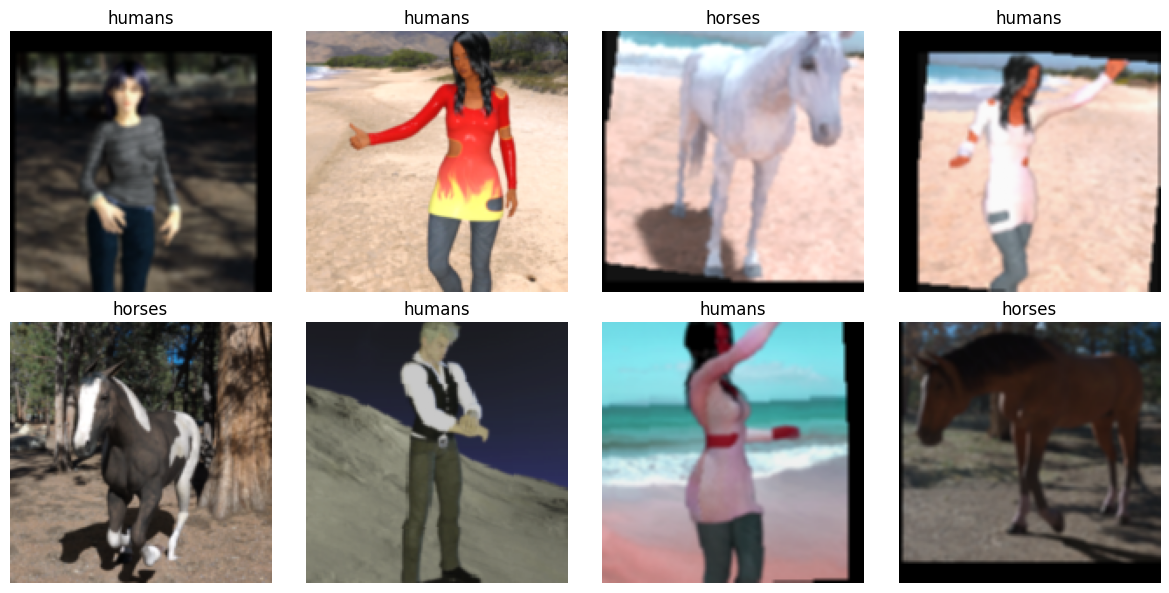

In [16]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")


# Получаем батч данных
images, labels = next(iter(train_loader))

# Визуализируем
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(images[i].numpy().transpose((1, 2, 0)))
    axes[i].set_title(class_names[labels[i]])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 18 * 18, 64),
            nn.ReLU(),
            nn.Dropout(0.6),  # От переобучения
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [18]:
model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(
    model.parameters(), lr=0.001, weight_decay=0.01
)  # + регуляризация
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [19]:
# Функции для обучения
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (output > 0.5).float()
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [20]:
def validate_epoch(model, dataloader, criterion, device):  # Считаем метрики
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device).float().unsqueeze(1)

            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            predicted = (output > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_probs.extend(output.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    # Вычисляем ROC-AUC
    auc_score = roc_auc_score(all_targets, all_probs)

    return epoch_loss, epoch_acc, auc_score, all_probs, all_targets

In [ ]:
num_epochs = 5
train_losses = []
val_losses = []
train_accs = []
val_accs = []
auc_scores = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc, auc_score, _, _ = validate_epoch(
        model, test_loader, criterion, device
    )

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    auc_scores.append(auc_score)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"\tTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"\tVal Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"\tROC-AUC: {auc_score:.4f}")
    if epoch != num_epochs - 1:
        print("=" * 50)

Epoch 1/5:
	Train Loss: 0.4187, Train Acc: 0.8396
	Val Loss: 1.0249, Val Acc: 0.9531
	ROC-AUC: 0.9699
Epoch 2/5:
	Train Loss: 0.1635, Train Acc: 0.9370
	Val Loss: 0.1719, Val Acc: 0.9688
	ROC-AUC: 0.9830
Epoch 3/5:
	Train Loss: 0.1266, Train Acc: 0.9520
	Val Loss: 3.0639, Val Acc: 0.8945
	ROC-AUC: 0.9659
Epoch 4/5:
	Train Loss: 0.1254, Train Acc: 0.9572
	Val Loss: 1.7129, Val Acc: 0.9609
	ROC-AUC: 0.9727
Epoch 5/5:
	Train Loss: 0.1060, Train Acc: 0.9584
	Val Loss: 0.6130, Val Acc: 0.9727
	ROC-AUC: 0.9838


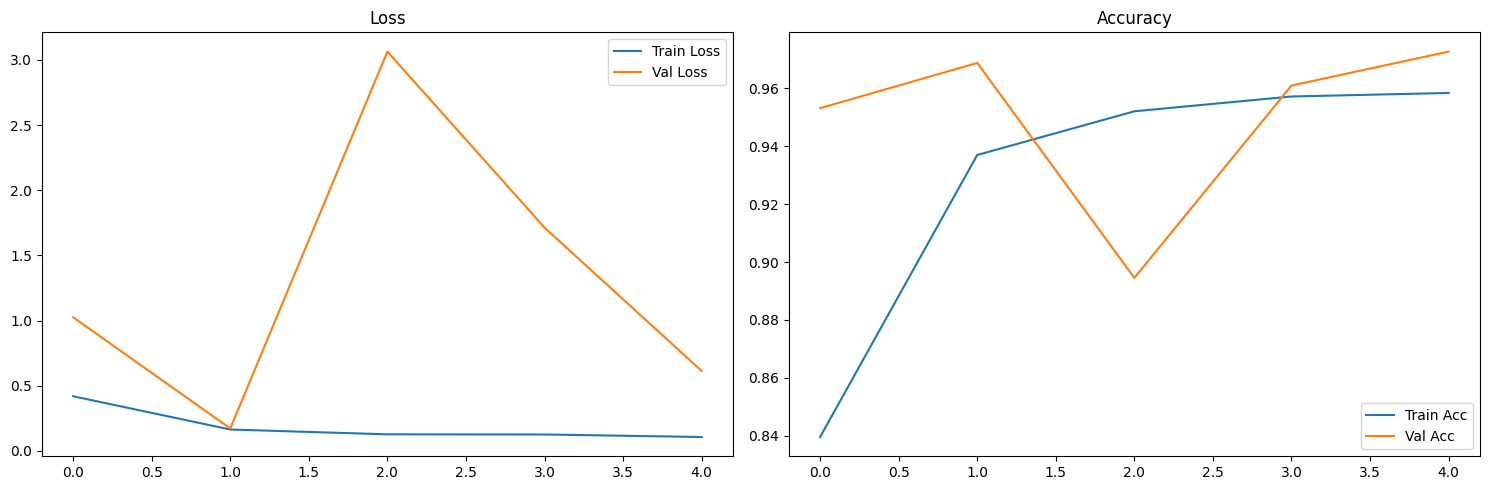

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

**От переобучения не спаслись**

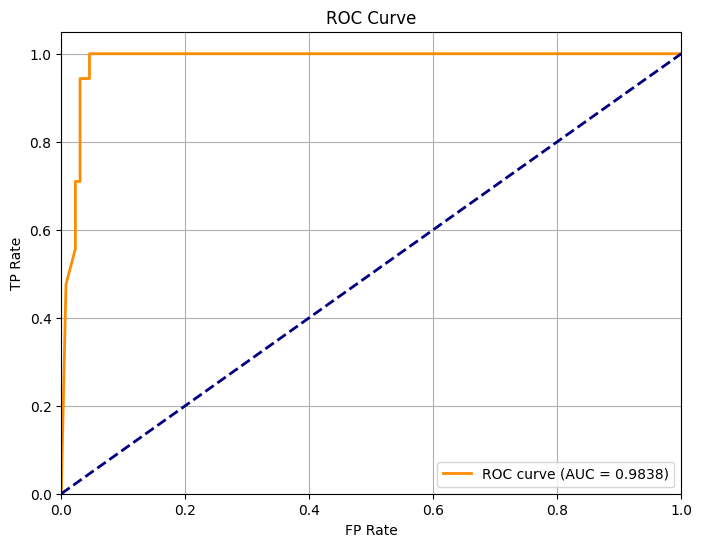

In [23]:
final_val_loss, final_val_acc, final_auc, all_probs, all_targets = validate_epoch(
    model, test_loader, criterion, device
)

fpr, tpr, thresholds = roc_curve(all_targets, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {final_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [24]:
torch.save(model.state_dict(), os.path.join(models_path, "model.pth"))